In [377]:
import numpy as np
from mnist.loader import MNIST
import matplotlib.pyplot as plt
import glob
import os
import h5py
import librosa
import umap
import soundfile as sf

from tqdm import tqdm
from pathlib import Path
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='poster')

sample_rate = 16000 #minimum 8000 for sf.write 
clip_length=5

5 second clip splitter

In [88]:
def split(loaded_audio, file_name, clip_length = 2):
    chunk_samples = int(clip_length * sample_rate)
    chunks = [loaded_audio[i:i + chunk_samples] for i in range(0, len(loaded_audio), chunk_samples)]
    for i, chunk in enumerate(chunks): #thank u stack for this cool iterative
        output_file = f"fma_generated/{file_name}{i}.mp3"
        sf.write(output_file, chunk, sample_rate)
    
temp, _ = librosa.load('./fma_small/000/000002.mp3', sr=sample_rate)
temp = librosa.util.normalize(temp)
split(temp, '000002')

#total 8000 tracks
def load_batches(root_path, sample_rate, batch_size, clip_length = 5, output_dir='./fma_generated'):
    os.makedirs(output_dir, exist_ok=True)
    file_paths=[]
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(root, file))
                #print(file)
                
    np.random.seed(88)
    np.random.shuffle(file_paths)
    
    
    chunk_samples = int(clip_length * sample_rate) #actual number of samples per chunkclip
    
    
    file_index = 0
    batch_index = 0
    while file_index < len(file_paths):
        batch_clips=[]
        bathchs=[]
        while len(batch_clips)<batch_size and file_index < len(file_paths):
            file_path = file_paths[file_index]
            try:
                #print(f"processing {os.path.basename(file_path)}")
                
                audio, _ = librosa.load(file_path, sr=sample_rate)
                filename = os.path.splitext(os.path.basename(file_path))[0]
                
                clip_index = 0
                for i in range(0,len(audio), chunk_samples):
                    chunk = audio[i:i+chunk_samples]
                    
                    if len(chunk) == chunk_samples: #exactly 5 seconds
                        clip_filename = f"{filename}{clip_index:01d}.mp3" #single digit index :o
                        clip_path = os.path.join(output_dir, clip_filename)
                        
                        sf.write(clip_path, chunk, sample_rate)
                        batch_clips.append(chunk.copy()) #avoid ref issues
                        bathchs.append(clip_path)
                        clip_index += 1
                        
                        if len(batch_clips) >= batch_size:
                            break
            except Exception as e:
                #print(f"error loading {file_path}: {str(e)}")
                continue
            file_index+=1
        if len(batch_clips) > 0:
            print(f"batch {batch_index+1} with {len(batch_clips)} clips")
            
            yield batch_clips.copy(), bathchs.copy()
            del batch_clips, bathchs
            batch_index += 1
            
        else: break

In [89]:
def clear_generated(generated_dir='./fma_generated'):
    if os.path.exists(generated_dir):
        for file in tqdm(os.listdir(generated_dir)):
            if file.endswith('.mp3'):
                os.remove(os.path.join(generated_dir, file))
        os.rmdir(generated_dir)
        print(f"deleted absolutely everything within the following. directory. {generated_dir}")

In [90]:
clear_generated('./fma_generated')
batch_size = 1000 #how many clips, not how many files r processed. btw
big_data = load_batches('./fma_small', sample_rate, batch_size, clip_length) #generator function
batches=[]
pathches=[]


small_data, file_paths = next(big_data)
batches.append(small_data)
pathches.append(file_paths)

100%|██████████| 37/37 [00:00<00:00, 1724.23it/s]


deleted absolutely everything within the following. directory. ./fma_generated
batch 1 with 1000 clips


In [91]:
print(len(batches[0])) #first batch is 100 clips
print(len(batches[0][0])) #each clip is 30sec*5512 samples
print(batches[0][0]) #each sample 
print(np.mean(batches[0][0]))
print(np.std(batches[0][0]))

1000
80000
[-1.7075305e-10 -1.1975139e-09  1.4381516e-09 ...  2.1903120e-01
  2.0611468e-01  1.5005562e-01]
-7.7387097e-07
0.1252519


choose either standardization or normalization. normalize for models
https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

In [419]:
import scipy
import sklearn.preprocessing
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

def into_mfccs_quick(audio, sample_rate):
    mfcc=librosa.feature.mfcc(y=audio, sr=sample_rate)
    #print(mfcc)
    if mfcc.max() == mfcc.min():
        return False
    return mfcc

def into_spectral_contrast(audio, sample_rate):
    S = np.abs(librosa.stft(audio))
    spectral_contrast=librosa.feature.spectral_contrast(S=S, sr=sample_rate)
    if spectral_contrast.max() == spectral_contrast.min():
        return False
    return normalize(spectral_contrast, axis=1)

def into_melspecs(audio, sample_rate):
    mel_spec=librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    #mel_db=librosa.power_to_db(mel_spec, ref=np.max) #scale to 1.0? perhaps??
    #librosa.display.specshow(mel_db, fmax=None, sr=sample_rate, x_axis='time', y_axis='mel')
    #plt.colorbar(format='%+2.0f dB')
    
    if mel_spec.max() == mel_spec.min():
        #i'm getting nans???
        return False
    
    #mel_normalized=2 * (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min()) - 1
    flattened = mel_spec.flatten()
    #mel_standardized = (mel_db - np.mean(mel_db)) / np.std(mel_db)
    #flattened = mel_standardized.flatten()
    return flattened

def into_textures(mel_spec, power = 2.0): #mel-frequency cepstrum. timbre
    if mel_spec is False or mel_spec is None:
        return False
    try: 
        logged = np.log(mel_spec + np.full_like(mel_spec, 1e-5))
        dct_powered = scipy.fft.dct(np.power(logged, power))
        normalized_textures = (dct_powered - np.mean(dct_powered)) / (np.std(dct_powered))
        return normalized_textures
    except Exception as e:
        print(f"{e}")
        return False

def into_freqs(audio, sample_rate):
    output, _, probabilities = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sample_rate, pad_mode='constant', n_thresholds = 10)
    output = np.nan_to_num(output, -1)
    #512 step
    return output, probabilities

def fourier_tempogram(audio, sample_rate):
    return librosa.feature.fourier_tempogram(y=audio, sr=sample_rate, win_length=128)

def tonal_centroid(audio, sample_rate):
    return librosa.feature.tonnetz(y=audio, sr=sample_rate)

test, testprob = into_freqs(batches[0][3], sample_rate)
test2 = into_textures(into_melspecs(batches[0][0], sample_rate))
test3 = into_mfccs_quick(batches[0][3], sample_rate)
test4 = tonal_centroid(batches[0][3], sample_rate)
# print(f"{test2.shape}\n{test}")
# print(f"{test3.shape}\n{test}")
print(f"{test4.shape}\n{test}")

(6, 157)
[83.84733628 83.84733628 83.84733628 84.33305896 83.84733628  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.

filtering out that one clip that's not the right length

In [420]:
%%time
batches_mels=[]
pathches_mels=[]
freqs=[]
probs=[]
tempos=[]
tones=[]

temp=[]
tempfreqs=[]
tempprobs=[]
tempmpograms=[]
temptones=[]
print(f'initial lengths:\n batches[0]: {len(batches[0])} \n pathches[0]: {len(pathches[0])}')
for i, clip in enumerate(tqdm(batches[0], desc='into freqs processing')):
   target_length = 1 + int(np.floor((clip_length * sample_rate)/512)) + 1 # 512 is default hop
   
   #mel_specs = into_melspecs(clip, sample_rate)
   harmonic, percussive = librosa.effects.hpss(clip, margin=8)
   mel_texture = into_spectral_contrast(clip, sample_rate)
   mel_texture = librosa.util.fix_length(mel_texture, size = target_length, axis=1)
   #mel_texture = into_mfccs_quick(clip, sample_rate)
   fourier_temp = fourier_tempogram(percussive, sample_rate)
   tonnetz = tonal_centroid(harmonic, sample_rate)
   tonnetz = librosa.util.fix_length(tonnetz, size = target_length, axis=1)
   #mel_harmonics, probabilities = into_freqs(clip, sample_rate)
   if mel_texture is False:
      print(f'failure at {i} spectrogram')
      #temp.append(False)
      tempfreqs.append(False)
      #tempprobs.append(False)
      tempmpograms.append(False)
      temptones.append(False)
      continue
   # mel_texture = into_textures(mel_specs)
   # if mel_texture is False:
   #    print(f'failure at {i} texture')
   #    temp.append(False)
   #    tempfreqs.append(False)
   #    tempprobs.append(False)
   #    continue
   
   temp.append(mel_texture) 
   #tempfreqs.append(mel_harmonics) #replaced freqs with tones
   #tempprobs.append(probabilities)
   tempmpograms.append(fourier_temp)
   temptones.append(tonnetz)
   
   
   
   
batches_mels.append(temp)
#freqs.append(tempfreqs)
tempos.append(tempmpograms)
tones.append(temptones)
#probs.append(tempprobs)
pathches_mels.append(pathches[0])

lengths = [len(i) for i in batches_mels[0] if i is not False]
most_common_length = max(set(lengths), key=lengths.count)
filtered_paths = [path for mel, path in zip(batches_mels[0], pathches[0]) if mel is not False and len(mel) == most_common_length]
#filtered_freqs = [freq for mel, freq in zip(batches_mels[0], freqs[0]) if mel is not False and len(mel) == most_common_length]
filtered_tempos = [tempo for mel, tempo in zip(batches_mels[0], tempos[0]) if mel is not False and len(mel) == most_common_length]
filtered_tones = [tone for mel, tone in zip(batches_mels[0], tones[0]) if mel is not False and len(mel) == most_common_length]

#filtered_probs = [prob for mel, prob in zip(batches_mels[0], probs[0]) if mel is not False and len(mel) == most_common_length]
filtered_mels = [mel for mel in batches_mels[0] if mel is not False and len(mel) == most_common_length]

print(f"\nsummary!")
print(f"initial total: {len(batches[0])}")
print(f"filtered mels count: {len(filtered_mels)}")
print(f"filtered paths count: {len(filtered_paths)}")

batches_mels[0] = np.array(filtered_mels, dtype=np.float32)
#freqs[0] = filtered_freqs
tempos[0] = filtered_tempos
tones[0] = filtered_tones
#probs[0] = filtered_probs
pathches_mels[0] = filtered_paths
tempos[0]= np.array(tempos[0])
tones[0] = np.array(tones[0])

#flatten everything:
batches_mels[0] = batches_mels[0].reshape(batches_mels[0].shape[0], -1)  # (30, 20*157) = (30, 3140)
tempos[0] = tempos[0].reshape(tempos[0].shape[0], -1)  # (30, 193*158) = (30, 30494)
tones[0] = tones[0].reshape(tones[0].shape[0], -1)  # (30, 6*157) = (30, 942)


initial lengths:
 batches[0]: 200 
 pathches[0]: 200


into freqs processing: 100%|██████████| 200/200 [00:40<00:00,  4.94it/s]


summary!
initial total: 200
filtered mels count: 200
filtered paths count: 200
CPU times: user 37 s, sys: 5.77 s, total: 42.7 s
Wall time: 40.6 s


In [421]:
print(f"batches_mels[0] shape: {batches_mels[0].shape}")
print(f"tempos[0] shape: {tempos[0].shape}")
print(f"tones[0] shape: {tones[0].shape}")

print(f"tones[0][0]: {tones[0][0]}")

batches_mels[0] shape: (200, 1106)
tempos[0] shape: (200, 10270)
tones[0] shape: (200, 948)
tones[0][0]: [-2.79345105e-03 -4.88654788e-02 -6.17349946e-02 -4.24224921e-02
 -3.02549237e-02  6.77348085e-02  1.84966457e-01  1.51584648e-01
  1.54453436e-01  2.07176589e-01  1.65384567e-01  8.42230439e-02
  6.95172661e-02  6.21772157e-02  1.00728131e-01  8.86640315e-02
  2.31920129e-03 -7.19894196e-02 -1.10442243e-01 -1.27151762e-01
 -1.16021289e-01 -9.84410800e-02 -6.79687683e-02  1.30127517e-02
  6.76886548e-02  6.71919677e-02  3.06982857e-02  4.23182497e-02
  5.85182997e-02  6.81064123e-02  8.26649947e-02  6.06957275e-02
  9.23637756e-03 -5.83117308e-02 -8.37341559e-02 -7.19601133e-02
 -8.79567926e-02 -2.57655829e-02  6.37611356e-02  1.37927065e-01
  1.89256725e-01  2.39764896e-01  2.51121431e-01  2.71710439e-01
  3.11315497e-01  2.57201227e-01  2.23729685e-01  1.77439233e-01
  1.84000728e-01  2.63291165e-01  2.83128610e-01  2.45957909e-01
  1.96849500e-01  1.69996370e-01  2.46622031e-01  

normalization

In [438]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ---------- helper ---------------------------------------------------------
def whiten_and_weight(block, d_ref):
    """
    block  : (n_samples, d_block)  raw feature matrix
    d_ref  : int, reference dimension (usually the smallest block's d)

    Returns: weighted, whitened block   (n_samples, d_block)
    """
    # 1) per-coordinate z-score  (mean 0, std 1)
    block = StandardScaler().fit_transform(block)

    # 2) weight so this block's expected squared-norm matches other blocks
    d_block = block.shape[1]
    weight  = np.sqrt(d_ref / d_block)   # √dim scaling
    return block * weight
# --------------------------------------------------------------------------

# choose the smallest block's dimension as reference
d_ref = tones[0].shape[1]     # 948

# apply to every block
Xm = whiten_and_weight(batches_mels[0], d_ref)      # (200, 1106)
Xt = whiten_and_weight(np.real(tempos[0]), d_ref)   # (200, 10270)
Xo = whiten_and_weight(tones[0],         d_ref)     # (200, 948)

# concatenate for UMAP / clustering / whatever
combined = np.hstack([Xm, Xt, Xo])                     # (200, 1106+10270+948)

metrics

In [424]:
import numba
import numpy as np
def create_euclidean_both(mels_dim, tempo_dim, tone_dim):#freq_count):
    mels_dim = int(mels_dim)
    #freq_count = int(freq_count)
    @numba.njit()
    def euclidean_timbre(a, b):
        return np.linalg.norm(a[:mels_dim]-b[:mels_dim])
        

    # @numba.njit()
    # def euclidean_freq(a, b):
        
    #     freq_dists = np.nan_to_num(np.log(a[mels_dim:mels_dim+freq_count]/b[mels_dim:mels_dim+freq_count]), nan=-1.0)
    #     timbretemp = 0.0
    #     freqtemp = 0.0
    #     for i in range(len(freq_dists)):
    #         if freq_dists[i]<0.0: #either clip was just unsure? then timbre dominates
    #             timbretemp += (a[i*128]-b[i*128])**2
    #             continue
    #         note_dist=min(abs(freq_dists[i]%0.69315), abs(freq_dists[i]%-0.69315)) #~log 2
    #         freqtemp+=(note_dist**2)*(a[mels_dim+freq_count+i])*(b[mels_dim+freq_count+i])
            
    #         #more confident pitches have more distance. but this does push noisy stuff together
    #     return ((np.sqrt(freqtemp))*128+np.sqrt(timbretemp))*5
    @numba.njit()
    def euclidean_tempo(a, b):
        return np.linalg.norm(a[mels_dim:mels_dim+tempo_dim]-b[mels_dim:mels_dim+tempo_dim])
    
    @numba.njit()
    def euclidean_tonnetz(a, b):
        tonnetz_dist = np.linalg.norm(a[mels_dim+tempo_dim:]-b[mels_dim+tempo_dim:])
        return tonnetz_dist
    
    @numba.njit()
    def euclidean_both(a, b):
        return euclidean_timbre(a, b) * euclidean_tempo(a, b) * euclidean_tonnetz(a, b)
        #return euclidean_timbre(a, b),euclidean_tempo(a, b)*0.6,euclidean_tonnetz(a, b)*70#+euclidean_freq(a, b)
    
    return euclidean_both
combined = np.real(np.concatenate([batches_mels[0], tempos[0], tones[0]], axis=1)) #freqs[0], probs[0]], axis=1)
euclidean_both = create_euclidean_both(batches_mels[0].shape[1], tempos[0].shape[1], tones[0].shape[1]) #freq_count)
timbresum=0
temposum=0
tonnetzsum=0
#freqsum=0
for i in range(20):
    for j in range(i+1, 20):
        addtimbre, addtempo, addtonnetz = euclidean_both(combined[i], combined[j])
        timbresum+=addtimbre
        temposum+=addtempo
        tonnetzsum+=addtonnetz
        #freqsum+=addfreq
print(f"timbre: {timbresum}, tempo: {temposum}, tonnetz: {tonnetzsum}")


In [425]:
combined = np.real(np.concatenate([batches_mels[0], tempos[0], tones[0]], axis=1)) #freqs[0], probs[0]], axis=1)
#imaginary +0 for some reason
print(combined.shape)


(200, 12324)


In [443]:
%%time
#combined = np.real(np.concatenate([batches_mels[0], tempos[0], tones[0]], axis=1)) #freqs[0], probs[0]], axis=1)
#imaginary +0 for some reason
print(combined.shape)
euclidean_both = create_euclidean_both(batches_mels[0].shape[1], tempos[0].shape[1], tones[0].shape[1]) #freq_count)
#currently not using metric
unsup_embedding = umap.UMAP(n_neighbors=5).fit_transform(combined)

(200, 12324)
CPU times: user 231 ms, sys: 82.1 ms, total: 313 ms
Wall time: 187 ms


/Users/user/Desktop/coding comps/transition/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [444]:
print(len(batches_mels[0]))
print(len(filtered_mels))
print(len(pathches_mels[0]))

200
200
200


thank you gpt. i would never read all this documentation

In [461]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import os
import flask
import librosa
import numpy as np

# After your UMAP processing and filtering...
# Create DataFrame from your clip data
def create_clip_dataframe(umap_embedding, pathches_mels):
    """
    Create DataFrame for clips instead of full audio files
    """
    df = pd.DataFrame({
        'UMAP1': umap_embedding[:, 0],
        'UMAP2': umap_embedding[:, 1], 
        'Clip_Path': pathches_mels,
        'Original_File': [extract_original_filename(path) for path in pathches_mels],
        'Clip_Index': [extract_clip_index(path) for path in pathches_mels]
    })
    
    # Create audio URLs for serving
    df['audio_url'] = df['Clip_Path'].apply(get_clip_audio_url)
    
    return df

def extract_original_filename(clip_path):
    """Extract original filename from clip path"""
    # ./fma_generated/000002_clip_000.mp3 -> 000002
    basename = os.path.basename(clip_path)
    # Remove extension and clip suffix
    name_without_ext = os.path.splitext(basename)[0]
    # Split on '_clip_' and take first part
    if '_clip_' in name_without_ext:
        return name_without_ext.split('_clip_')[0]
    return name_without_ext

def extract_clip_index(clip_path):
    """Extract clip index from clip path"""
    # ./fma_generated/000002_clip_000.mp3 -> 0
    basename = os.path.basename(clip_path)
    name_without_ext = os.path.splitext(basename)[0]
    if '_clip_' in name_without_ext:
        try:
            return int(name_without_ext.split('_clip_')[1])
        except (ValueError, IndexError):
            return 0
    return 0

def get_clip_audio_url(clip_path):
    """Convert clip path to URL for serving"""
    # ./fma_generated/000002_clip_000.mp3 -> /audio/000002_clip_000.mp3
    filename = os.path.basename(clip_path)
    return f'/audio/{filename}'

# Create your DataFrame
df = create_clip_dataframe(unsup_embedding, pathches_mels[0])

# Initialize Dash app
app = dash.Dash(__name__)

# Set up audio serving directory (your generated clips)
AUDIO_DIR = os.path.abspath('fma_generated')  # Changed from 'fma_small' to 'fma_generated'

@app.server.route('/audio/<path:filename>')
def serve_audio(filename):
    """Serve audio clips from fma_generated directory"""
    if '..' in filename or filename.startswith('/'):
        flask.abort(404)
    return flask.send_from_directory(AUDIO_DIR, filename)

# Create the scatter plot
fig = px.scatter(
    df, 
    x="UMAP1", 
    y="UMAP2", 
    hover_data=["Original_File", "Clip_Index"], 
    custom_data=['audio_url'],
    title="UMAP",
    labels={'UMAP1': 'Arbitrary Dimension 1', 'UMAP2': 'Arbitrary Dimension 2'}
)

fig.update_layout(
    autosize=True,
    height=600  # Set minimum height
)

# Update hover template to show clip info
fig.update_traces(
    hovertemplate="<b>Original File:</b> %{customdata[1]}<br>" +
                  "<b>Clip Index:</b> %{customdata[2]}<br>" +
                  "<b>UMAP1:</b> %{x}<br>" +
                  "<b>UMAP2:</b> %{y}<extra></extra>"
)

app.layout = html.Div([
    #html.H1("analysis", style={'textAlign': 'center'}),
    #html.P(f"this many!!! {len(df)} audio clips", style={'textAlign': 'center'}),
    dcc.Graph(id="scatter", figure=fig),
    html.Div([
        html.Audio(id='audio-player', controls=True, src=''),
        html.Div(id='clip-info', style={'marginTop': '10px'})
    ], style={'margin': '20px'})
])

@app.callback(
    [Output('audio-player', 'src'),
     Output('clip-info', 'children')],
    Input('scatter', 'clickData')
)
def update_audio(clickData):
    if clickData and "points" in clickData:
        audio_url = clickData["points"][0]["customdata"][0]
        
        # Get point index to show clip info
        point_idx = clickData["points"][0]["pointIndex"]
        clip_info = html.Div([
            html.P(f"file path: {df.iloc[point_idx]['Original_File']}{df.iloc[point_idx]['Clip_Index']:01d}.mp3"),
            html.P(f"({df.iloc[point_idx]['UMAP1']:.3f}, {df.iloc[point_idx]['UMAP2']:.3f})")
        ])
        
        return audio_url, clip_info
    
    return '', html.P("")

if __name__ == "__main__":
    print(f"Serving {len(df)} audio clips")
    print(f"Audio files served from: {AUDIO_DIR}")
    app.run(debug=True) 

Serving 200 audio clips
Audio files served from: /Users/user/Desktop/coding comps/transition/fma_generated


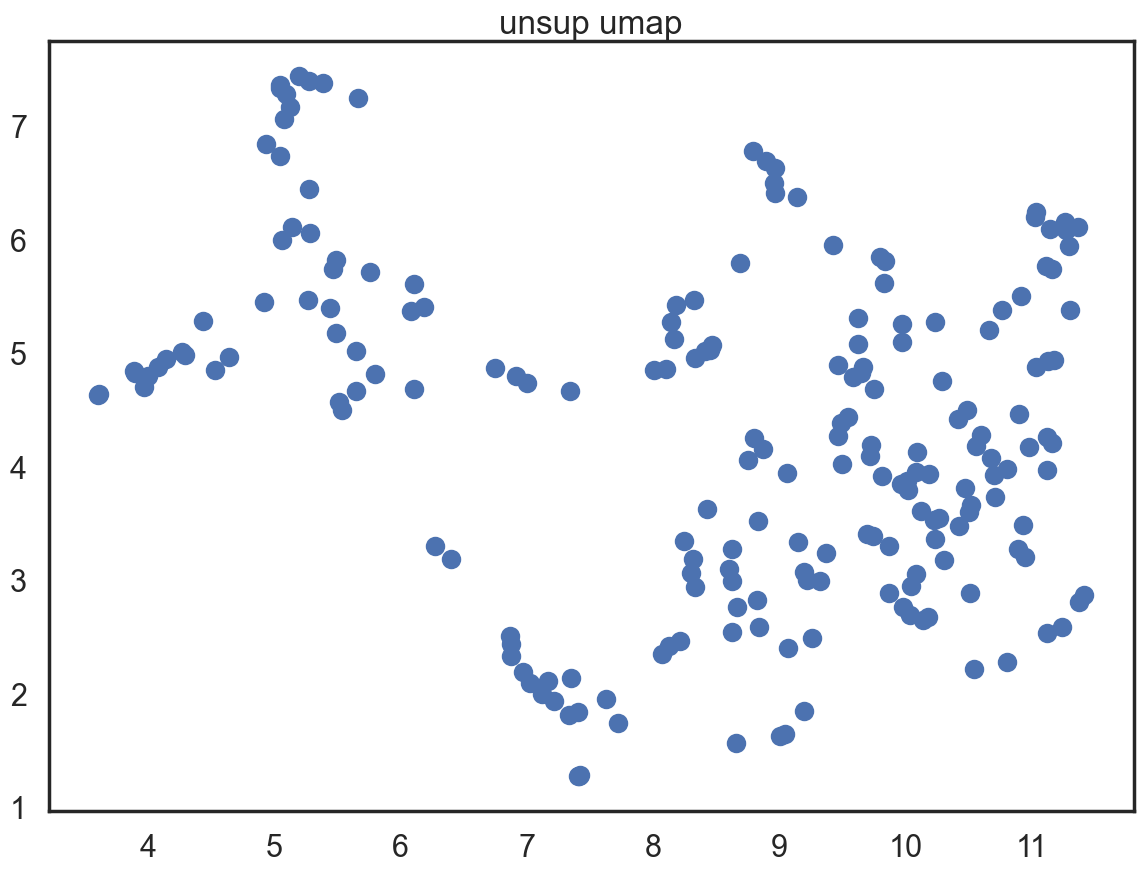

In [446]:
plt.figure(figsize=(14, 10))
plt.scatter(unsup_embedding[:, 0], unsup_embedding[:, 1])
plt.title('unsup umap')
plt.show()

okay so integer linear programming is totally unfeasible since solvers still explore something on the scale of literally every path. thus i shall use heuristic stuff. wait though. if i have a metric i believe in this is this basically slightly obfuscated direct programming? no. because umap guarantees distances satisfy triangle inequality. not sure if my metirc was originally triangleproof tho

okay so basically i'm going to implement christofides

In [447]:
christdists=np.zeros((batch_size, batch_size))
dists=[]
dist_ids=[]
for i in tqdm(range(batch_size)):
    for j in range(i+1, batch_size):
        edist=np.linalg.norm(unsup_embedding[i]-unsup_embedding[j])
        dists.append(edist)
        dist_ids.append((i, j))
        christdists[i, j]=edist

100%|██████████| 200/200 [00:00<00:00, 1076.37it/s]


In [448]:
class disjointdataset:
    #parent array of reps
    def __init__(self, size):
        self.parent=list(range(size))
    def find(self, i):
        if self.parent[i]==i:
            return i
        return self.find(self.parent[i])
    def union(self, i, j):
        self.parent[self.find(i)]=self.find(j)

In [449]:
#find mst. kruskal's
sorted_pairs=sorted(zip(dists, dist_ids), key=lambda x:x[0])
mst = []
dd = disjointdataset(batch_size)
i=0


while len(mst)<batch_size-1 and i < len(sorted_pairs):
    #would including the smallest so far create a cycle
    dist, edge = sorted_pairs[i]
    x, y = edge
    
    if dd.find(x) != dd.find(y):
        dd.union(x, y)
        #if it does not, append it, otherwise skip it
        mst.append((x, y, dist))
    
    i+=1

In [450]:
#find odd degree vertices; create perfect matching of 
degrees = np.zeros(batch_size)
for u, v, distance in mst:
    degrees[u]+=1
    degrees[v]+=1

odd_degree_vertices = [i for i in range(batch_size) if degrees[i]%2==1] #indices
    

so for this exact point i'm a little lazy and will just 

In [451]:
#TAKES EXTREMELY LONG!!!!
import networkx as net

def minimum_perfect_matching(odd_vertices, distance_matrix):
    graph = net.Graph()
    for vertex in odd_vertices:
        graph.add_node(vertex)
    for i in range(len(odd_vertices)):
        for j in range(i+1, len(odd_vertices)):
            graph.add_edge(odd_vertices[i], odd_vertices[j], weight = christdists[i, j])
            
    matching = net.algorithms.matching.min_weight_matching(graph, weight = 'weight')
    return matching
matching_edges = minimum_perfect_matching(odd_degree_vertices, dist)

In [452]:
mpm = [(u, v, christdists[u][v]) for u, v in matching_edges]
print(mpm)

[(146, 148, np.float64(4.073318004608154)), (26, 21, np.float64(0.0)), (30, 116, np.float64(2.5922791957855225)), (159, 169, np.float64(3.1725151538848877)), (34, 153, np.float64(2.4025559425354004)), (9, 72, np.float64(2.267371892929077)), (178, 179, np.float64(1.1653687953948975)), (87, 104, np.float64(4.082736492156982)), (14, 31, np.float64(2.090902805328369)), (131, 137, np.float64(4.187827110290527)), (174, 7, np.float64(0.0)), (28, 103, np.float64(1.8439456224441528)), (16, 25, np.float64(7.116755962371826)), (24, 38, np.float64(1.688932180404663)), (79, 99, np.float64(1.8175798654556274)), (105, 118, np.float64(4.335240840911865)), (11, 175, np.float64(4.821584224700928)), (46, 47, np.float64(1.2551007270812988)), (41, 130, np.float64(1.246719241142273)), (1, 78, np.float64(1.683259129524231)), (63, 66, np.float64(2.94004487991333)), (18, 128, np.float64(3.22906494140625)), (62, 125, np.float64(2.6535279750823975)), (60, 48, np.float64(0.0)), (184, 185, np.float64(0.43495595455

heirholzer's alg for eularian path finding

In [453]:
from multiset import *

together = mst + mpm #every edge now has even degree
adjacency_dictionary={}
for u, v, weight in together:
    if u not in adjacency_dictionary:
        adjacency_dictionary[u]=[]
    adjacency_dictionary[u].append((v,weight))
    if v not in adjacency_dictionary:
        adjacency_dictionary[v]=[]
    adjacency_dictionary[v].append((u, weight))

checkpoint: recreate extra_walk


In [454]:
def heirholzers(graph):
    if len(graph)==0:
        return []
    temp_path=[0]
    total_path=[]
    while len(temp_path)>0:
        current_node=temp_path[len(temp_path)-1]
        if len(graph[current_node])>0:
            next_node, _ = graph[current_node].pop()
            temp_path.append(next_node)
            
            for i, (neighbor, weight) in enumerate(graph[next_node]):
                if neighbor == current_node:
                    del graph[next_node][i]
                    break
        else:
            total_path.append(temp_path.pop())
    total_path.reverse()
    return total_path
graph = {node: neighbors.copy() for node, neighbors in adjacency_dictionary.items()}
extra_walk=heirholzers(graph)



In [455]:
print(extra_walk)
seen= [None] * batch_size
for i, node in enumerate(extra_walk):
    if seen[node] is None:
        seen[node]=[i]
    else: 
        seen[node].append(i)
print(adjacency_dictionary)
remove = []
for node, sightings in enumerate(seen): #"node" seen at "sightings", index is of walk
    if len(sightings)>1:
        minimum = 0
        at = 0
        if node==0:
            continue
        for sighting in sightings:
            left=0
            right=0
            over=0
            for neighbor, distance in adjacency_dictionary[extra_walk[sighting]]:
                if neighbor==extra_walk[sighting-1]: 
                    left=distance
                if neighbor==extra_walk[sighting+1]: 
                    right=distance
            for neighbor, distance in adjacency_dictionary[extra_walk[sighting-1]]:
                if neighbor==extra_walk[sighting+1]:
                    over=distance
            if over-left-right<minimum:
                minimum=over-left-right
                at = sighting
        for sighting in sightings:
            if sighting != at:
                remove.append(sighting)
                

[0, 61, 29, 4, 77, 105, 118, 115, 158, 57, 60, 48, 13, 10, 172, 48, 173, 121, 73, 8, 3, 82, 81, 80, 79, 99, 133, 2, 108, 32, 117, 15, 37, 145, 87, 104, 101, 166, 127, 190, 189, 126, 89, 92, 136, 137, 131, 192, 197, 78, 1, 3, 132, 14, 31, 78, 168, 30, 116, 56, 153, 34, 27, 28, 103, 169, 159, 116, 113, 111, 91, 146, 148, 9, 72, 107, 33, 36, 71, 70, 69, 68, 67, 66, 63, 131, 88, 100, 151, 102, 164, 153, 191, 188, 129, 127, 187, 125, 62, 169, 177, 8, 17, 76, 143, 165, 166, 64, 75, 192, 154, 152, 150, 58, 156, 60, 45, 94, 97, 93, 96, 21, 26, 85, 22, 184, 185, 175, 11, 128, 18, 42, 49, 21, 95, 98, 20, 157, 123, 149, 170, 179, 178, 176, 119, 184, 23, 183, 175, 25, 16, 19, 120, 122, 124, 163, 167, 142, 109, 65, 43, 174, 7, 194, 5, 99, 6, 90, 193, 13, 171, 9, 14, 135, 138, 139, 128, 186, 125, 114, 110, 112, 86, 46, 47, 161, 50, 52, 53, 51, 55, 54, 180, 155, 59, 160, 46, 83, 162, 87, 26, 195, 84, 12, 179, 147, 35, 38, 24, 25, 181, 182, 74, 73, 44, 30, 141, 106, 34, 140, 198, 40, 134, 144, 134, 72

In [456]:
remove.sort(reverse=True)
for i, node in enumerate(remove):
    del(extra_walk[node])
print(extra_walk)
walk = extra_walk.copy()
#don't run this multiple times

[0, 61, 29, 4, 77, 105, 118, 115, 158, 57, 13, 10, 172, 48, 173, 121, 73, 8, 3, 82, 81, 80, 79, 99, 133, 2, 108, 32, 117, 15, 37, 145, 87, 104, 101, 190, 189, 126, 89, 92, 136, 137, 131, 192, 197, 78, 1, 132, 14, 31, 168, 30, 116, 56, 153, 34, 27, 28, 103, 169, 159, 113, 111, 91, 146, 148, 9, 72, 107, 33, 36, 71, 70, 69, 68, 67, 66, 63, 88, 100, 151, 102, 164, 191, 188, 129, 127, 187, 125, 62, 177, 17, 76, 143, 165, 166, 64, 75, 154, 152, 150, 58, 156, 60, 45, 94, 97, 93, 96, 85, 22, 184, 185, 175, 11, 128, 18, 42, 49, 21, 95, 98, 20, 157, 123, 149, 170, 179, 178, 176, 119, 23, 183, 25, 16, 19, 120, 122, 124, 163, 167, 142, 109, 65, 43, 7, 194, 5, 6, 90, 193, 171, 135, 138, 139, 186, 114, 110, 112, 86, 46, 47, 161, 50, 52, 53, 51, 55, 54, 180, 155, 59, 160, 83, 162, 26, 195, 84, 12, 147, 35, 38, 24, 181, 182, 74, 44, 141, 106, 140, 198, 40, 144, 134, 174, 39, 199, 196, 41, 130, 0]


In [457]:

def path_sounds_like(output_directory="./fma_generated"):
    combined_audio=[]
    for index, location in enumerate(walk):
        file_path = pathches_mels[0][location]
        audio, _ = librosa.load(file_path, sr=sample_rate)
        combined_audio=np.concatenate([combined_audio,audio])
        if index>100:
            break
    print(np.shape(combined_audio))
    clip_name = f"00000000combined.mp3"
    clip_path = os.path.join(output_directory, clip_name)
    sf.write(clip_path, combined_audio, sample_rate)

path_sounds_like()

(8160000,)


In [462]:
import plotly.graph_objects as go
import plotly.express as px

# ------------------------------------------------------------
# 1.  Build a DataFrame (already done)
df = create_clip_dataframe(unsup_embedding, pathches_mels[0])

# ------------------------------------------------------------
# 2.  Your existing scatter
fig = px.scatter(
    df,
    x="UMAP1",
    y="UMAP2",
    hover_data=["Original_File", "Clip_Index"],
    custom_data=["audio_url"],
    title="UMAP",
    labels={"UMAP1": "Arbitrary Dimension 1",
            "UMAP2": "Arbitrary Dimension 2"}
)

# ------------------------------------------------------------
# 3.  Add a path trace
#    `walk` is an ordered list/array of indices into df/embedding
xs = df.loc[walk, "UMAP1"]
ys = df.loc[walk, "UMAP2"]

fig.add_trace(
    go.Scatter(
        x=xs,
        y=ys,
        mode="lines+markers",
        line=dict(color="red", width=2),
        marker=dict(size=6, symbol="circle"),
        name="Path"
    )
)

fig.update_layout(
    autosize=True,
    height=600
)

# ------------------------------------------------------------
# 4.  Dash layout stays the same
app.layout = html.Div([
    dcc.Graph(id="scatter", figure=fig),
    html.Div([
        html.Audio(id="audio-player", controls=True, src=""),
        html.Div(id="clip-info", style={"marginTop": "10px"})
    ], style={"margin": "20px"})
])


in conclusion christofides' sucks ASS!!!!?????